# [ EXPLORATION ] 16. 난 스케치를 할 테니 너는 채색을 하거라

### 목차 

    (1) 라이브러리 import 
    (2) 데이터 준비 
    (3) Generator 구성하기
    (4) Generator 재구성하기
    (5) Discriminator 구성하기
    (6) Training and test 

### 목표 

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.                           | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.<br>                                                        |
| **2** | pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.                               |
| **3** | 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.                                    | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다. |


### (1) 라이브러리 import 

In [1]:
# 모듈 로드
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

In [2]:
# 경고 무시
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

### (2) 데이터 준비 

In [3]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


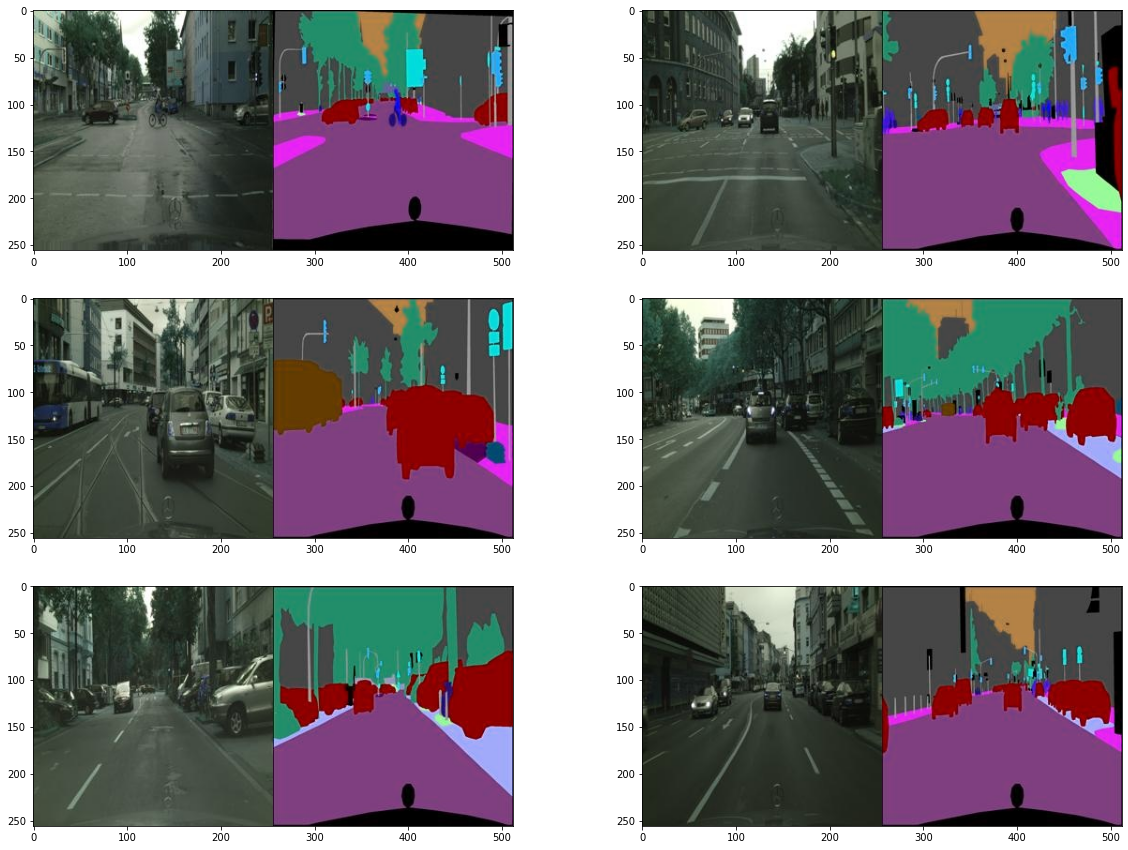

In [4]:
# 이미지 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [6]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

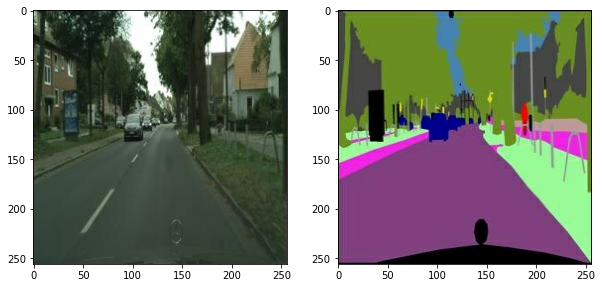

In [7]:
# 이미지 분리
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# Augmentation 적용
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(sketch, colored):
    # 두 이미지를 채널 축으로 연결 (3채널인 경우 6채널로 변환)
    stacked = tf.concat([sketch, colored], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    # 50%의 확률로 Refection padding 또는 constant padding 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 임의로 crop
    out = image.random_crop(padded, size=[256, 256, 6])

    # 50% 확률로 좌우상하 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

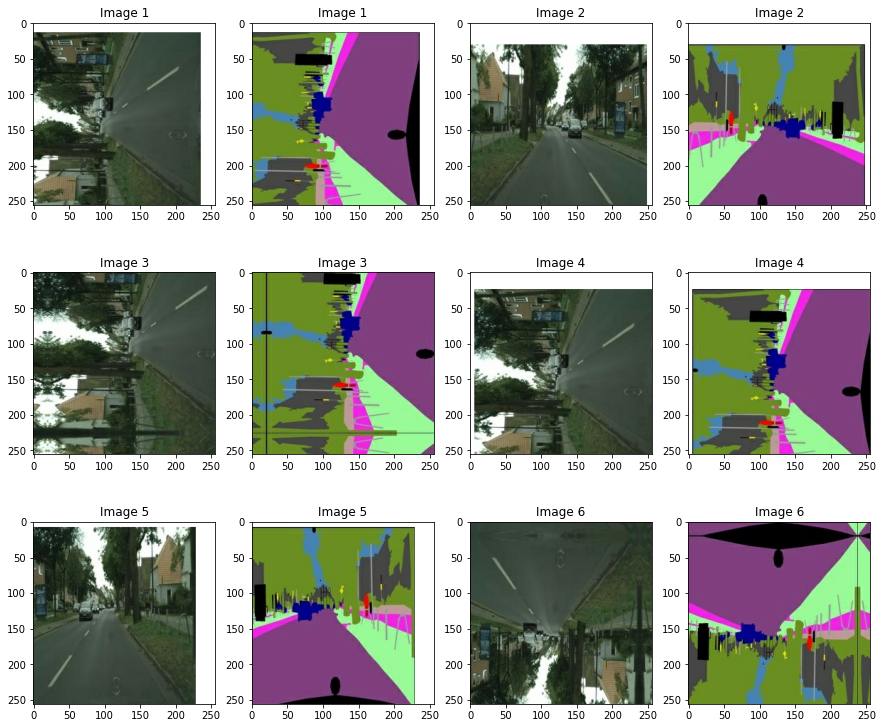

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [10]:
from tensorflow import data

# 학습 노드에서 sketch와 colored 순서가 다름에 주의
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

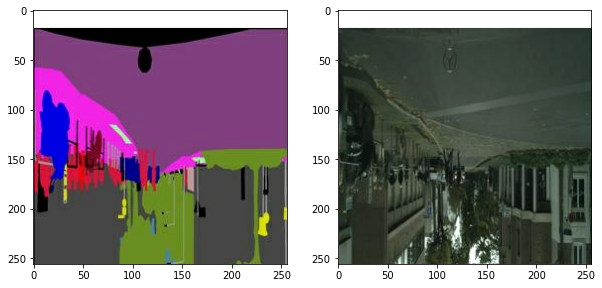

In [11]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

<br>

### (3) Generator 구성하기


In [12]:
# Encoder
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
# Decoder   
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### (4) Generator 재구성하기

In [14]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 Skip Connection에서 제외
        features = features[:-1]

        # feature의 역순으로 Skip Connection
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) # 가장 마지막 축(Channel) 기준으로 연결
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________


### (5) Discriminator 구성하기

In [16]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            # 1 만큼 ZeroPadding
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [18]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

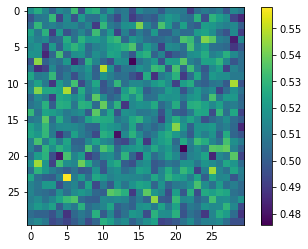

In [19]:
# 임의 테스트
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()


### (6) Training and test

In [20]:
# Loss Function
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [21]:
# Optimizer
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [22]:
# 학습 가중치 업데이트 함수
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [23]:
# 10 epoch 훈련
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9545                     
L1_loss:0.3644                     
Discriminator_loss:1.2471

EPOCH[1] - STEP[20]                     
Generator_loss:1.2511                     
L1_loss:0.2909                     
Discriminator_loss:1.3994

EPOCH[1] - STEP[30]                     
Generator_loss:1.0133                     
L1_loss:0.2299                     
Discriminator_loss:1.3716

EPOCH[1] - STEP[40]                     
Generator_loss:0.8830                     
L1_loss:0.2072                     
Discriminator_loss:1.2183

EPOCH[1] - STEP[50]                     
Generator_loss:0.7748                     
L1_loss:0.2072                     
Discriminator_loss:1.2128

EPOCH[1] - STEP[60]                     
Generator_loss:1.2777                     
L1_loss:0.2452                     
Discriminator_loss:1.1871

EPOCH[1] - STEP[70]                     
Generator_loss:0.8291                     
L1_loss:0.2040                    

In [24]:
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of valication examples :", len(os.listdir(val_path)))

number of valication examples : 5


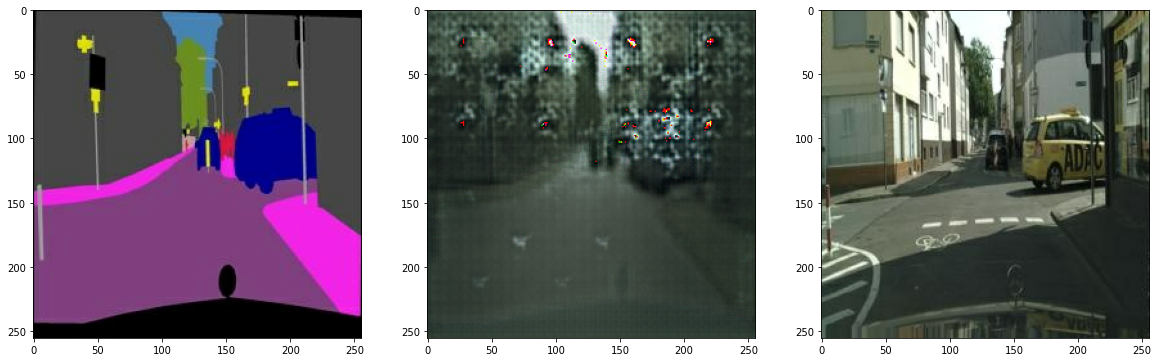

In [25]:
# 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [26]:
# 500 epochs train
EPOCHS = 500

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:2.1733                     
L1_loss:0.1733                     
Discriminator_loss:0.5413

EPOCH[1] - STEP[100]                     
Generator_loss:1.9929                     
L1_loss:0.1874                     
Discriminator_loss:0.6382

EPOCH[1] - STEP[150]                     
Generator_loss:0.7209                     
L1_loss:0.1575                     
Discriminator_loss:0.9818

EPOCH[1] - STEP[200]                     
Generator_loss:0.3142                     
L1_loss:0.1953                     
Discriminator_loss:1.7146

EPOCH[1] - STEP[250]                     
Generator_loss:1.2401                     
L1_loss:0.1550                     
Discriminator_loss:0.6722

EPOCH[2] - STEP[50]                     
Generator_loss:1.3888                     
L1_loss:0.1529                     
Discriminator_loss:0.9445

EPOCH[2] - STEP[100]                     
Generator_loss:0.7392                     
L1_loss:0.1894               

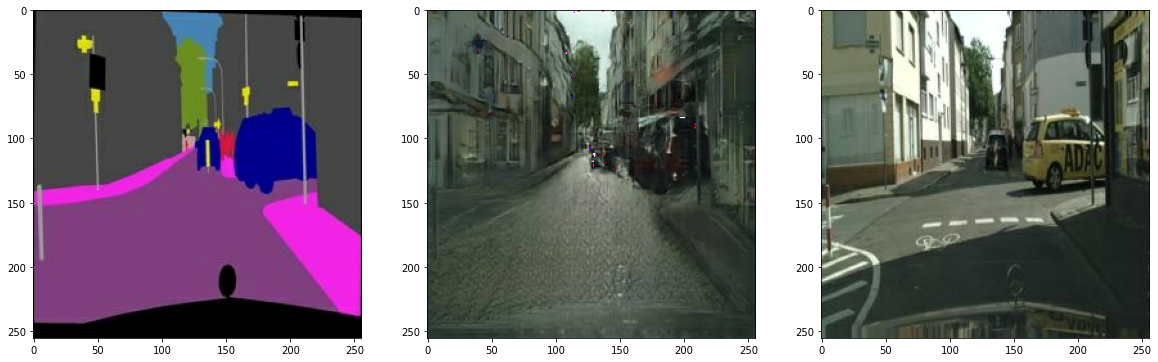

In [27]:
# 500 epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 회고 


- 금번 과제도 epoch 을 높여 결과를 내는건 시간이 너무 오래걸렸다. 10 에서 100을 해보고 200 300 400 500 이렇게 차근차근 높여가면서 결과를 비교하고 싶었으나 시간상의 제약으로 포기하고 언제 시간이 가능할 때 해보기로 생각했다. Epoch 값 500 을 입력한 결과는 정밀하고 뚜렷하다. 
<br>

- Epoch 100 보다 2배의 시간을 예상하고 200을 해봤는데 그것보다 훨씬 더 오래걸렸고 Epoch 값 100 과 200은 큰 차이가 없었다.Epoch 10 과 100/200 은 위에서 보이듯 차이가 꽤 났다. 

### Epoch 100 

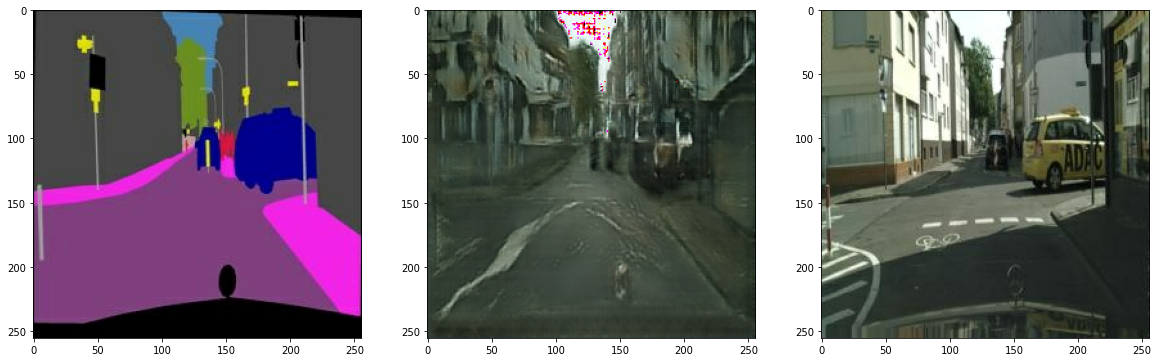




###  Epoch 200

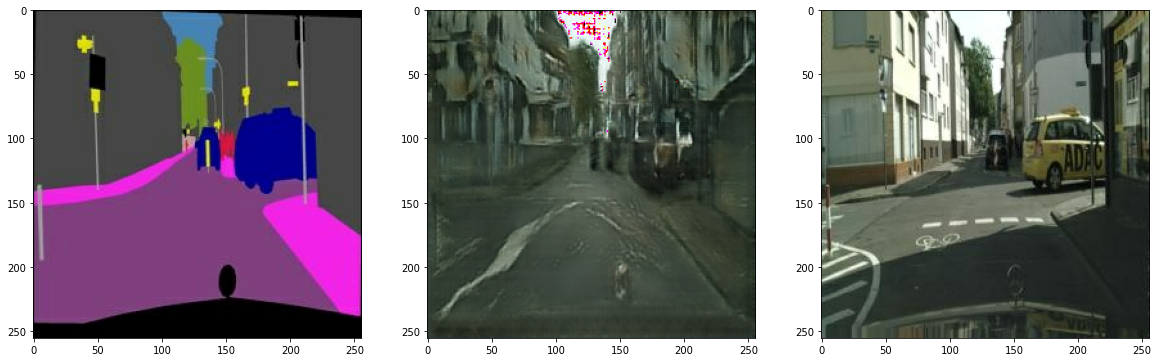

- 이번 과제를 진행하고도 GAN 의 이론적인 원리는 완전히 이해했다고 하기는 힘든데. 고잉 디퍼를 거치며 기회가 있을거라 생각한다. 어렵고 시간이 많이 걸리는 작업이었지만 그래도 epoch 가 돌아가는 동안 결과 그림이 궁금하고 나름 재미도 있었다.  
